In [10]:
# System libraries
import os
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Deep Learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, 
                                     BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D, 
                                     Reshape, Multiply, Add, Input, Permute, Concatenate, Lambda)
from tensorflow.keras import regularizers
from tensorflow.keras.applications import MobileNetV2

# Settings
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings("ignore")

print('✅ Modules loaded successfully')

✅ Modules loaded successfully


In [ ]:
# Define Dataset Paths
train_data_dir = "/content/Training"
test_data_dir = "/content/Testing"

# Function to create a DataFrame from file paths
def create_dataframe(data_dir):
    filepaths = []
    labels = []
    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return pd.DataFrame({'filepaths': filepaths, 'labels': labels})

# Create DataFrames
train_df = create_dataframe(train_data_dir)
ts_df = create_dataframe(test_data_dir)

print(f"Training samples: {len(train_df)}")
print(f"Testing samples: {len(ts_df)}")

Training samples: 5712
Testing samples: 1311


In [6]:
# Split the 'Test' folder into Validation (50%) and Test (50%)
valid_df, test_df = train_test_split(ts_df, train_size=0.5, shuffle=True, random_state=123)
print(f"Validation samples: {len(valid_df)}")
print(f"Final Test samples: {len(test_df)}")

Validation samples: 655
Final Test samples: 656


In [7]:
# --- NOVELTY: Custom Preprocessing (CLAHE) ---
def apply_clahe_preprocessing(img):
    """
    Applies Contrast Limited Adaptive Histogram Equalization (CLAHE)
    to enhance tumor visibility in dark MRI regions.
    """
    img = img.astype(np.uint8) 
    # Convert RGB to YUV (Luminance channel holds the details)
    img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_yuv[:,:,0] = clahe.apply(img_yuv[:,:,0])
    img_final = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    return img_final / 255.0  # Normalize to [0, 1]

# Configuration
batch_size = 16
img_size = (224, 224)

# Generators with Custom Preprocessing
tr_gen = ImageDataGenerator(preprocessing_function=apply_clahe_preprocessing)
ts_gen = ImageDataGenerator(preprocessing_function=apply_clahe_preprocessing)

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', 
                                       target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', 
                                       target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', 
                                      target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


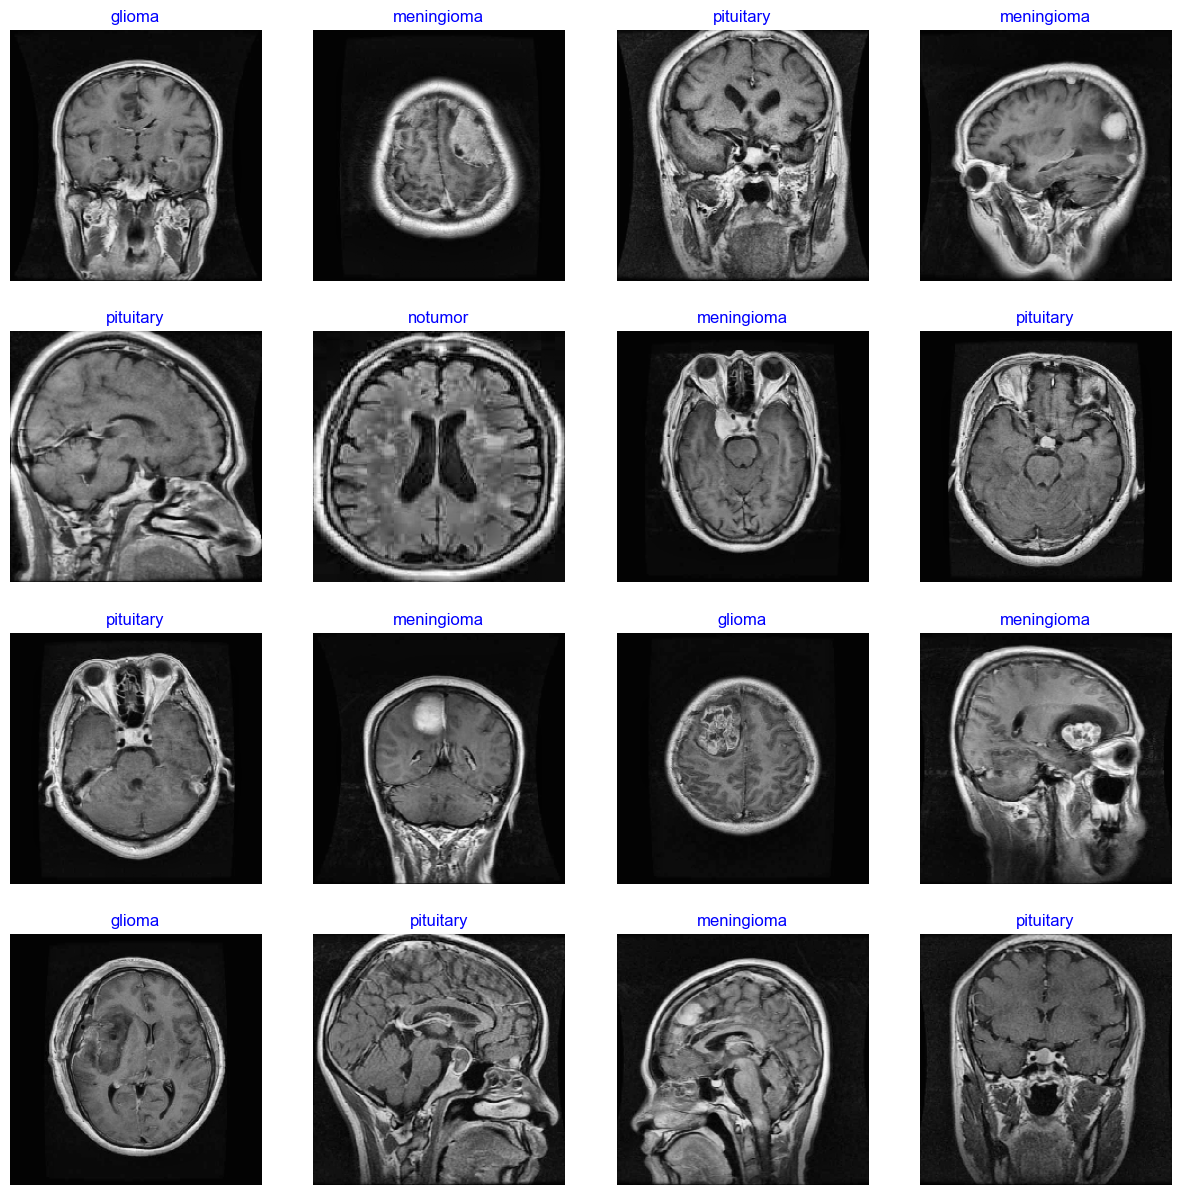

In [8]:
# Visualize a batch to see if CLAHE worked
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize=(15, 15))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i])
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.show()

In [ ]:
def cbam_block(cbam_feature, ratio=8):
    # Channel Attention
    channel = cbam_feature.shape[-1]
    shared_layer_one = Dense(channel // ratio, activation='relu', kernel_initializer='he_normal', use_bias=True)
    shared_layer_two = Dense(channel, kernel_initializer='he_normal', use_bias=True)
    
    avg_pool = shared_layer_two(shared_layer_one(GlobalAveragePooling2D()(cbam_feature)))
    max_pool = shared_layer_two(shared_layer_one(GlobalMaxPooling2D()(cbam_feature)))
    
    channel_feature = Activation('sigmoid')(Add()([Reshape((1,1,channel))(avg_pool), Reshape((1,1,channel))(max_pool)]))
    channel_feature = Multiply()([cbam_feature, channel_feature])
    
    # Spatial Attention (FIXED)
    avg_s = tf.reduce_mean(channel_feature, axis=3, keepdims=True)
    max_s = tf.reduce_max(channel_feature, axis=3, keepdims=True)
    concat = Concatenate(axis=3)([avg_s, max_s])
    spatial_feature = Conv2D(1, 7, padding='same', activation='sigmoid', use_bias=False)(concat)
    
    return Multiply()([channel_feature, spatial_feature])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,123,428 (11.91 MB)

 Trainable params: 865,444 (3.30 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Build Att-MobileNet
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True
for layer in base_model.layers[:-40]:
    layer.trainable = False

x = cbam_block(base_model.output)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.016))(x)
x = Dropout(0.5)(x)
output = Dense(len(train_gen.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(x=train_gen, epochs=15, validation_data=valid_gen, verbose=1)

✅ Model compiled with Unfrozen layers and Low Learning Rate.


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,123,428 (11.91 MB)

 Trainable params: 2,546,980 (9.72 MB)

 Non-trainable params: 576,448 (2.20 MB)

Epoch 1/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 124s 301ms/step - accuracy: 0.7880 - loss: 6.3421 - val_accuracy: 0.7664 - val_loss: 5.7785
Epoch 2/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 106s 297ms/step - accuracy: 0.9041 - loss: 4.9794 - val_accuracy: 0.8351 - val_loss: 4.7504
Epoch 3/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 106s 297ms/step - accuracy: 0.9293 - loss: 4.2012 - val_accuracy: 0.8779 - val_loss: 4.0163
Epoch 4/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 105s 295ms/step - accuracy: 0.9473 - loss: 3.5934 - val_accuracy: 0.8916 - val_loss: 3.4894
Epoch 5/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 107s 299ms/step - accuracy: 0.9657 - loss: 3.0782 - val_accuracy: 0.9084 - val_loss: 3.0030
Epoch 6/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 108s 301ms/step - accuracy: 0.9706 - loss: 2.6528 - val_accuracy: 0.9420 - val_loss: 2.5345
Epoch 7/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 109s 305ms/step - accuracy: 0.9841 - loss: 2.2781 - val_accuracy: 0.9481 - val_loss: 2.1917
Epoch 8/15
357/357 ━━━━━━━━━━━━━━━━━━━━ 117s 328ms/step - accuracy: 0.9869 -

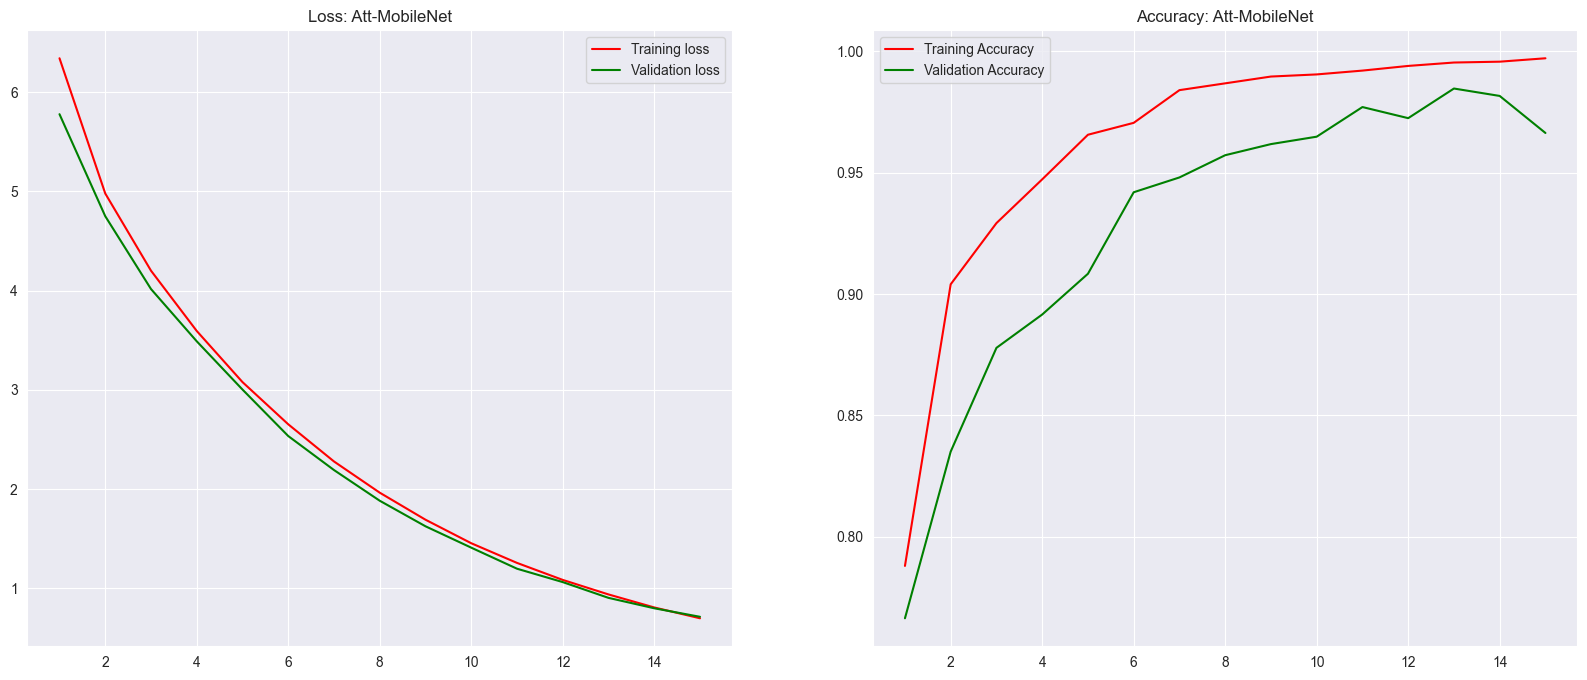

In [18]:
# Plot Accuracy and Loss
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
Epochs = [i+1 for i in range(len(tr_acc))]

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.title('Loss: Att-MobileNet')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.title('Accuracy: Att-MobileNet')
plt.legend()
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 238ms/step - accuracy: 1.0000 - loss: 0.6325
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - accuracy: 0.9844 - loss: 0.6747
Test Accuracy: 98.44%
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 216ms/step


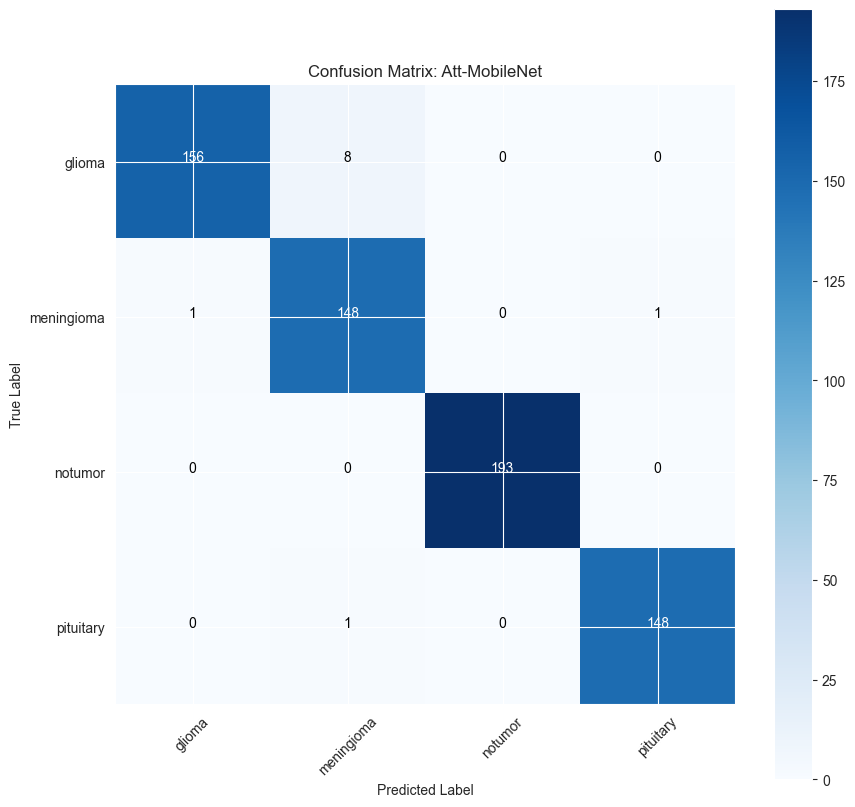

              precision    recall  f1-score   support

      glioma       0.99      0.95      0.97       164
  meningioma       0.94      0.99      0.96       150
     notumor       1.00      1.00      1.00       193
   pituitary       0.99      0.99      0.99       149

    accuracy                           0.98       656
   macro avg       0.98      0.98      0.98       656
weighted avg       0.98      0.98      0.98       656



In [19]:
# Predict on Test Set
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps=test_steps, verbose=1)
test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)

print(f"Test Accuracy: {test_score[1]*100:.2f}%")

preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

# Plot Matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix: Att-MobileNet')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(classification_report(test_gen.classes, y_pred, target_names=classes))

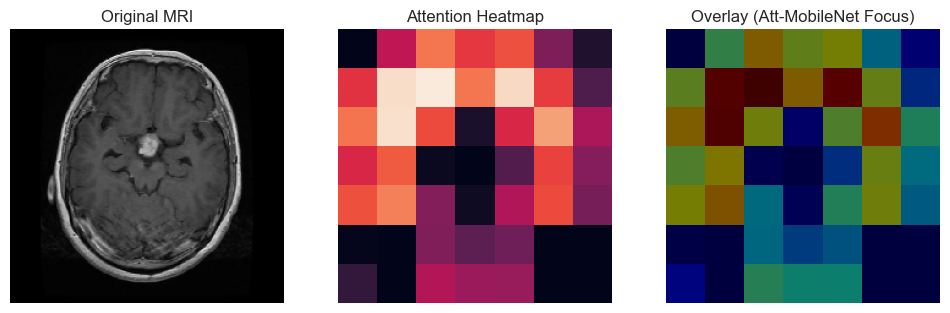

In [15]:
# --- Grad-CAM: Visual Proof of Focus ---
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Select a random test image
img_path = test_df.iloc[10]['filepaths'] # Index 10 is usually a good tumor example
img = keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# "Conv_1" is usually the last conv layer in MobileNetV2
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="Conv_1")

plt.figure(figsize=(12, 6))
plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Original MRI")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(heatmap)
plt.title("Attention Heatmap")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(img)
plt.imshow(heatmap, alpha=0.5, cmap='jet')
plt.title("Overlay (Att-MobileNet Focus)")
plt.axis('off')
plt.show()